In [1]:
import sys, os
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem, Descriptors
import sklearn
from sklearn.metrics import confusion_matrix, precision_score,recall_score 
from sklearn.metrics import f1_score, precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('dataset/feature_set_all/train_set_2.csv')
df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
df.head(2)

,num,name,BBclass,Check,smiles,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,...,MFP_2039,MFP_2040,MFP_2041,MFP_2042,MFP_2043,MFP_2044,MFP_2045,MFP_2046,MFP_2047,MFP_2048
0,1,Propanolol,1,2,CC(C)NCC(O)COc1cccc2ccccc12,9.843954,-0.498733,9.843954,0.299333,0.837506,...,1,0,0,0,0,0,0,0,0,0
1,2,Terbutylchlorambucil,1,2,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,11.682268,-0.409691,11.682268,0.134704,0.474821,...,0,0,0,0,0,0,0,0,0,0


Check features with NaN or infinite value

In [3]:
columns = df.columns.to_numpy()
check_features = columns[df.isin([np.inf, -np.inf, np.NaN]).any(axis=0).to_numpy()].tolist()
check_features, len(check_features)

(['Ipc'], 1)

In [4]:
lowVar_features = df.std()[df.std() < 0.14].index.tolist()
len(lowVar_features)

1351

In [5]:
#features = [x[0] for x in Descriptors._descList]
Fingerprints = ['MFP_%d'%(i+1) for i in range(2048)]
descriptors = ['HeavyAtomMolWt','NHOHCount','NOCount','RingCount']
features = Fingerprints + descriptors
features = [x for x in features if x not in check_features+lowVar_features]
len(features)

743

In [6]:
df.BBclass.value_counts()/len(df)

1    0.763562
0    0.236438
Name: BBclass, dtype: float64

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

split_method = ''

if split_method == 'random':
    train, test = train_test_split(df, test_size=0.2, random_state=10)
    print ('train:', len(train), 'test:', len(test))
    
    X_train = np.c_[train[features]]
    y_train = np.c_[train['BBclass']]
    X_test = np.c_[test[features]]
    y_test = np.c_[test['BBclass']]
    
    
else:
    df["MW_cat"] = np.ceil(df["MolWt"]/100.0)
    df["MW_cat"].where(df["MW_cat"] < 6, 6.0, inplace=True)
    
    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
    for train_index, test_index in split.split(df, df["MW_cat"]):
        train = df.loc[train_index]
        test = df.loc[test_index]
        
    print ('train:', len(train), 'test:', len(test))    
    X_train = np.c_[train[features]]
    y_train = np.c_[train['BBclass']]
    X_test = np.c_[test[features]]
    y_test = np.c_[test['BBclass']]

In [7]:
X_train = np.c_[df[features]]
y_train = np.c_[df['BBclass']]

### 1. Try a Balanced RandomForestClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

#RF_model = BalancedRandomForestClassifier(n_estimators=400,oob_score=True, random_state=10)
RF_model = BalancedRandomForestClassifier(n_estimators=400,
                                          criterion='gini',
                                          oob_score=True, random_state=10)

RF_model.fit(X_train, y_train[:,0])
y_train_predict = RF_model.predict(X_train)
y_oob_predict = np.argmax(RF_model.oob_decision_function_, axis=1)

In [9]:
new = pd.read_csv('dataset/feature_set_all/test_set.csv')
X_test1 = np.c_[new[features]]
y_test1 = np.c_[new['BBclass']]
y_test1_predict = RF_model.predict(X_test1)
len(new)

33

confusion matrix

In [10]:
confusion_matrix(y_train, y_oob_predict)

array([[ 385,   77],
       [ 167, 1325]])

In [11]:
confusion_matrix(y_test1, y_test1_predict)

array([[16,  1],
       [ 0, 16]])

precision (for BBBP prediction, TP/(TP+FP) is more important)

In [12]:
precision_score(y_train, y_oob_predict)

0.9450784593437945

In [13]:
precision_score(y_test1, y_test1_predict)

0.9411764705882353

recall   (TP/(TP+FN)), also called sensitivity

In [14]:
recall_score(y_train, y_oob_predict)

0.8880697050938338

In [15]:
recall_score(y_test1, y_test1_predict)

1.0

Accuracy ((TP+TN/(all cases)))

In [16]:
from sklearn.metrics import accuracy_score

accuracy_score(y_train, y_oob_predict)

0.8751279426816786

In [17]:
accuracy_score(y_test1, y_test1_predict)

0.9696969696969697

f1_score (2/(1/recall+1/precision))

In [18]:
f1_score(y_train, y_oob_predict)

0.9156876295784381

In [19]:
f1_score(y_test1, y_test1_predict)

0.9696969696969697

specificity (TN/(TN+FP))

In [20]:
tn, fp, fn, tp = confusion_matrix(y_train, y_oob_predict).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

specificity, sensitivity

(0.8333333333333334, 0.8880697050938338)

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test1, y_test1_predict).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)

specificity, sensitivity

(0.9411764705882353, 1.0)

ROC curve for oob prediction

In [22]:
y_probas = RF_model.oob_decision_function_
y_scores = y_probas[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train, y_scores)

In [23]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

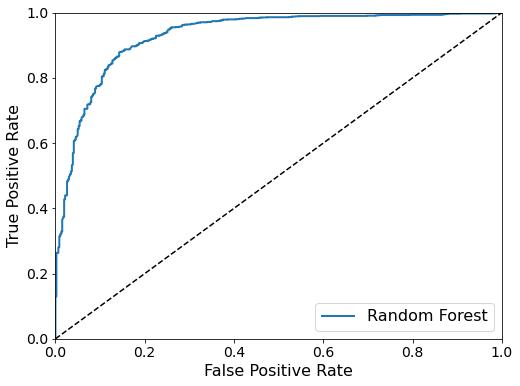

In [24]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [25]:
roc_auc_score(y_train, y_scores)

0.9305836031707346

ROC curve for test set

In [26]:
y_probas1 = RF_model.predict_proba(X_test1)
y_scores1 = y_probas1[:, 1] 
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test1, y_scores1)

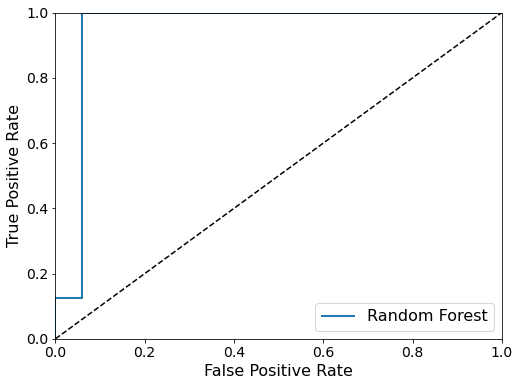

In [27]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [28]:
roc_auc_score(y_test1, y_scores1)

0.9485294117647058

Precision vs Recall for oob prediction

In [29]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [30]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.axis([0, 1, 0, 1])

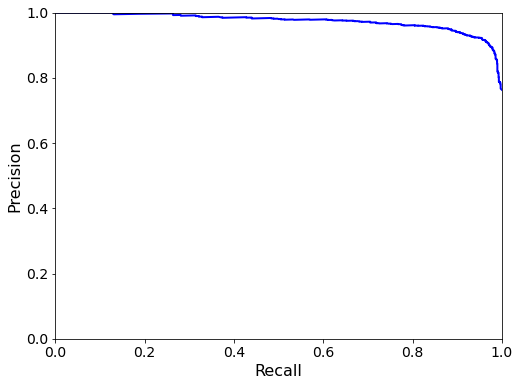

In [31]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [32]:
sklearn.metrics.auc(recalls, precisions)

0.9741003242082283

Precision vs Recall for test set

In [33]:
precisions, recalls, thresholds = precision_recall_curve(y_test1, y_scores1)

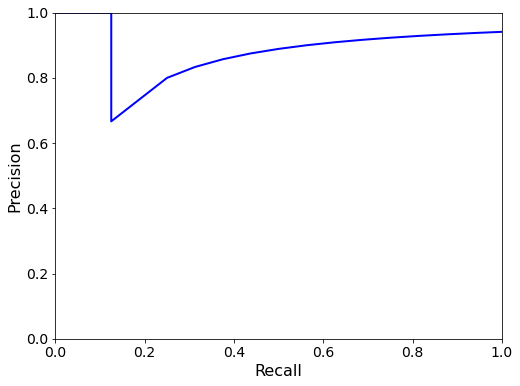

In [34]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [35]:
sklearn.metrics.auc(recalls, precisions)

0.8899912026290703

### 2. Save the RF model

In [36]:
import pickle

In [37]:
output = 'model/RF_model.pickle.dat'
pickle.dump(RF_model, open(output, "wb"))

In [38]:
pickle.dump(features, open('model/RF_features.pickle',"wb"))